# Susceptibility to substitution

## 1 Setup

Flags and settings.

In [1]:
SAVE_FIGURES = False
PAPER_FEATURES = ['frequency', 'aoa', 'clustering', 'letters_count', 'synonyms_count',
                  'orthographic_density']
BIN_COUNT = 4

Imports and database setup.

In [2]:
import pandas as pd
import seaborn as sb
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from progressbar import ProgressBar
from statsmodels.stats.proportion import multinomial_proportions_confint

%cd -q ..
from brainscopypaste.conf import settings
%cd -q notebooks
from brainscopypaste.mine import Model, Time, Source, Past, Durl
from brainscopypaste.db import Substitution
from brainscopypaste.utils import init_db, session_scope, stopwords
engine = init_db()

## 2 Susceptibility in absolute and sentence-relative values

Build our data.

In [3]:
model = Model(time=Time.continuous, source=Source.majority, past=Past.all, durl=Durl.all, max_distance=1)
data = []

with session_scope() as session:
    substitutions = session.query(Substitution.id).filter(Substitution.model == model)
    print("Got {} substitutions for model {}".format(substitutions.count(), model))
    substitution_ids = [id for (id,) in substitutions]

for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        # Prepare these arrays for stopword-checking.
        dslice = slice(substitution.start,
                       substitution.start + len(substitution.destination.tokens))
        lemmas = substitution.source.lemmas[dslice]
        tokens = substitution.source.tokens[dslice]
        tags = substitution.source.tags[dslice]
        
        for feature in Substitution.__features__:
            sentence_values, _ = substitution.source_destination_features(feature)
            sentence_values_rel, _ = substitution.source_destination_features(
                feature, sentence_relative='median')
            source_type, _ = Substitution.__features__[feature]
            # Stopword-check the arrays.
            words = getattr(substitution.source, source_type)[dslice]
            for i, (word, lemma, token, tag) in enumerate(zip(words, lemmas, tokens, tags)):
                if (token in stopwords) or (lemma in stopwords):
                    # Drop stopwords from this analysis since we exclude stopword-substitutions.
                    continue
                data.append({'cluster_id': substitution.source.cluster.sid,
                             'destination_id': substitution.destination.sid,
                             'occurrence': substitution.occurrence,
                             'source_id': substitution.source.sid,
                             'feature': feature,
                             'word': word,
                             'POS': tag,
                             'target': i == substitution.position,
                             'value': sentence_values[i],
                             'value_rel': sentence_values_rel[i]})

original_susties = pd.DataFrame(data)
del data

Got 14485 substitutions for model Model(time=Time.continuous, source=Source.majority, past=Past.all, durl=Durl.all, max_distance=1)


  0% (    1 of 14485) |                   | Elapsed Time: 0:00:04 ETA:  17:20:15

  0% (   87 of 14485) |                    | Elapsed Time: 0:00:05 ETA:  0:02:43

  1% (  159 of 14485) |                    | Elapsed Time: 0:00:06 ETA:  0:02:57

  1% (  182 of 14485) |                    | Elapsed Time: 0:00:06 ETA:  0:03:01

  1% (  268 of 14485) |                    | Elapsed Time: 0:00:07 ETA:  0:02:54

  2% (  363 of 14485) |                    | Elapsed Time: 0:00:08 ETA:  0:02:48

  3% (  454 of 14485) |                    | Elapsed Time: 0:00:09 ETA:  0:02:43

  3% (  544 of 14485) |                    | Elapsed Time: 0:00:10 ETA:  0:02:39

  4% (  628 of 14485) |                    | Elapsed Time: 0:00:11 ETA:  0:02:39

  5% (  725 of 14485) |#                   | Elapsed Time: 0:00:12 ETA:  0:02:35

  5% (  813 of 14485) |#                   | Elapsed Time: 0:00:13 ETA:  0:02:31

  6% (  888 of 14485) |#                   | Elapsed Time: 0:00:14 ETA:  0:02:33

  6% (  906 of 14485) |#                   | Elapsed Time: 0:00:15 ETA:  0:02:36

  6% (  968 of 14485) |#                   | Elapsed Time: 0:00:16 ETA:  0:02:42

  7% ( 1039 of 14485) |#                   | Elapsed Time: 0:00:17 ETA:  0:02:47

  7% ( 1087 of 14485) |#                   | Elapsed Time: 0:00:17 ETA:  0:02:50

  8% ( 1185 of 14485) |#                   | Elapsed Time: 0:00:18 ETA:  0:02:45

  8% ( 1268 of 14485) |#                   | Elapsed Time: 0:00:20 ETA:  0:02:52

  9% ( 1351 of 14485) |#                   | Elapsed Time: 0:00:21 ETA:  0:02:53

 10% ( 1449 of 14485) |##                  | Elapsed Time: 0:00:22 ETA:  0:02:46

 10% ( 1516 of 14485) |##                  | Elapsed Time: 0:00:23 ETA:  0:02:43

 11% ( 1597 of 14485) |##                  | Elapsed Time: 0:00:24 ETA:  0:02:39

 11% ( 1630 of 14485) |##                  | Elapsed Time: 0:00:24 ETA:  0:02:39

 11% ( 1709 of 14485) |##                  | Elapsed Time: 0:00:25 ETA:  0:02:45

 12% ( 1811 of 14485) |##                  | Elapsed Time: 0:00:26 ETA:  0:02:32

 13% ( 1907 of 14485) |##                  | Elapsed Time: 0:00:27 ETA:  0:02:27

 13% ( 1992 of 14485) |##                  | Elapsed Time: 0:00:28 ETA:  0:02:24

 14% ( 2075 of 14485) |##                  | Elapsed Time: 0:00:29 ETA:  0:02:24

 15% ( 2173 of 14485) |###                 | Elapsed Time: 0:00:30 ETA:  0:02:15

 15% ( 2263 of 14485) |###                 | Elapsed Time: 0:00:31 ETA:  0:02:13

 16% ( 2354 of 14485) |###                 | Elapsed Time: 0:00:32 ETA:  0:02:08

 16% ( 2445 of 14485) |###                 | Elapsed Time: 0:00:33 ETA:  0:02:07

 17% ( 2535 of 14485) |###                 | Elapsed Time: 0:00:34 ETA:  0:02:05

 18% ( 2608 of 14485) |###                 | Elapsed Time: 0:00:35 ETA:  0:02:09

 18% ( 2666 of 14485) |###                 | Elapsed Time: 0:00:36 ETA:  0:02:16

 18% ( 2716 of 14485) |###                 | Elapsed Time: 0:00:37 ETA:  0:02:17

 19% ( 2770 of 14485) |###                 | Elapsed Time: 0:00:38 ETA:  0:02:27

 19% ( 2834 of 14485) |###                 | Elapsed Time: 0:00:39 ETA:  0:02:30

 20% ( 2897 of 14485) |####                | Elapsed Time: 0:00:40 ETA:  0:02:34

 20% ( 2963 of 14485) |####                | Elapsed Time: 0:00:41 ETA:  0:02:51

 20% ( 3040 of 14485) |####                | Elapsed Time: 0:00:42 ETA:  0:02:55

 21% ( 3079 of 14485) |####                | Elapsed Time: 0:00:43 ETA:  0:03:00

 21% ( 3181 of 14485) |####                | Elapsed Time: 0:00:44 ETA:  0:02:48

 22% ( 3260 of 14485) |####                | Elapsed Time: 0:00:45 ETA:  0:02:35

 23% ( 3359 of 14485) |####                | Elapsed Time: 0:00:46 ETA:  0:02:26

 23% ( 3441 of 14485) |####                | Elapsed Time: 0:00:47 ETA:  0:02:15

 24% ( 3524 of 14485) |####                | Elapsed Time: 0:00:48 ETA:  0:02:09

 25% ( 3622 of 14485) |#####               | Elapsed Time: 0:00:49 ETA:  0:01:52

 25% ( 3710 of 14485) |#####               | Elapsed Time: 0:00:50 ETA:  0:01:49

 26% ( 3803 of 14485) |#####               | Elapsed Time: 0:00:51 ETA:  0:01:52

 26% ( 3903 of 14485) |#####               | Elapsed Time: 0:00:52 ETA:  0:01:49

 27% ( 3984 of 14485) |#####               | Elapsed Time: 0:00:53 ETA:  0:01:50

 28% ( 4058 of 14485) |#####               | Elapsed Time: 0:00:54 ETA:  0:01:53

 28% ( 4141 of 14485) |#####               | Elapsed Time: 0:00:55 ETA:  0:01:52

 28% ( 4165 of 14485) |#####               | Elapsed Time: 0:00:55 ETA:  0:01:50

 29% ( 4231 of 14485) |#####               | Elapsed Time: 0:00:56 ETA:  0:01:56

 29% ( 4302 of 14485) |#####               | Elapsed Time: 0:00:57 ETA:  0:02:00

 30% ( 4346 of 14485) |######              | Elapsed Time: 0:00:58 ETA:  0:02:05

 30% ( 4421 of 14485) |######              | Elapsed Time: 0:00:59 ETA:  0:02:05

 31% ( 4503 of 14485) |######              | Elapsed Time: 0:01:00 ETA:  0:02:10

 31% ( 4527 of 14485) |######              | Elapsed Time: 0:01:00 ETA:  0:02:14

 31% ( 4591 of 14485) |######              | Elapsed Time: 0:01:01 ETA:  0:02:16

 32% ( 4651 of 14485) |######              | Elapsed Time: 0:01:02 ETA:  0:02:24

 32% ( 4708 of 14485) |######              | Elapsed Time: 0:01:03 ETA:  0:02:22

 32% ( 4776 of 14485) |######              | Elapsed Time: 0:01:04 ETA:  0:02:21

 33% ( 4856 of 14485) |######              | Elapsed Time: 0:01:05 ETA:  0:02:16

 33% ( 4889 of 14485) |######              | Elapsed Time: 0:01:05 ETA:  0:02:16

 34% ( 4974 of 14485) |######              | Elapsed Time: 0:01:06 ETA:  0:02:12

 35% ( 5070 of 14485) |#######             | Elapsed Time: 0:01:07 ETA:  0:02:08

 35% ( 5161 of 14485) |#######             | Elapsed Time: 0:01:08 ETA:  0:01:58

 36% ( 5251 of 14485) |#######             | Elapsed Time: 0:01:09 ETA:  0:01:49

 36% ( 5352 of 14485) |#######             | Elapsed Time: 0:01:10 ETA:  0:01:37

 37% ( 5401 of 14485) |#######             | Elapsed Time: 0:01:11 ETA:  0:01:46

 37% ( 5432 of 14485) |#######             | Elapsed Time: 0:01:12 ETA:  0:01:40

 38% ( 5521 of 14485) |#######             | Elapsed Time: 0:01:13 ETA:  0:01:38

 38% ( 5613 of 14485) |#######             | Elapsed Time: 0:01:14 ETA:  0:01:39

 39% ( 5691 of 14485) |#######             | Elapsed Time: 0:01:15 ETA:  0:01:43

 39% ( 5763 of 14485) |#######             | Elapsed Time: 0:01:16 ETA:  0:01:47

 40% ( 5794 of 14485) |########            | Elapsed Time: 0:01:16 ETA:  0:01:48

 40% ( 5865 of 14485) |########            | Elapsed Time: 0:01:17 ETA:  0:01:58

 41% ( 5953 of 14485) |########            | Elapsed Time: 0:01:18 ETA:  0:01:43

 41% ( 5976 of 14485) |########            | Elapsed Time: 0:01:19 ETA:  0:01:43

 41% ( 6074 of 14485) |########            | Elapsed Time: 0:01:20 ETA:  0:01:39

 42% ( 6157 of 14485) |########            | Elapsed Time: 0:01:21 ETA:  0:01:41

 43% ( 6246 of 14485) |########            | Elapsed Time: 0:01:22 ETA:  0:01:37

 43% ( 6338 of 14485) |########            | Elapsed Time: 0:01:23 ETA:  0:01:28

 44% ( 6425 of 14485) |########            | Elapsed Time: 0:01:24 ETA:  0:01:22

 45% ( 6519 of 14485) |#########           | Elapsed Time: 0:01:25 ETA:  0:01:23

 45% ( 6620 of 14485) |#########           | Elapsed Time: 0:01:26 ETA:  0:01:20

 46% ( 6700 of 14485) |#########           | Elapsed Time: 0:01:27 ETA:  0:01:14

 46% ( 6790 of 14485) |#########           | Elapsed Time: 0:01:28 ETA:  0:01:13

 47% ( 6881 of 14485) |#########           | Elapsed Time: 0:01:29 ETA:  0:01:13

 47% ( 6951 of 14485) |#########           | Elapsed Time: 0:01:30 ETA:  0:01:18

 48% ( 7041 of 14485) |#########           | Elapsed Time: 0:01:31 ETA:  0:01:16

 48% ( 7062 of 14485) |#########           | Elapsed Time: 0:01:31 ETA:  0:01:15

 49% ( 7146 of 14485) |#########           | Elapsed Time: 0:01:32 ETA:  0:01:15

 50% ( 7243 of 14485) |##########          | Elapsed Time: 0:01:33 ETA:  0:01:18

 50% ( 7330 of 14485) |##########          | Elapsed Time: 0:01:34 ETA:  0:01:18

 51% ( 7424 of 14485) |##########          | Elapsed Time: 0:01:35 ETA:  0:01:14

 51% ( 7519 of 14485) |##########          | Elapsed Time: 0:01:36 ETA:  0:01:05

 52% ( 7605 of 14485) |##########          | Elapsed Time: 0:01:37 ETA:  0:01:04

 53% ( 7689 of 14485) |##########          | Elapsed Time: 0:01:38 ETA:  0:01:04

 53% ( 7786 of 14485) |##########          | Elapsed Time: 0:01:39 ETA:  0:01:00

 54% ( 7872 of 14485) |##########          | Elapsed Time: 0:01:40 ETA:  0:00:59

 55% ( 7967 of 14485) |###########         | Elapsed Time: 0:01:41 ETA:  0:00:57

 55% ( 8063 of 14485) |###########         | Elapsed Time: 0:01:42 ETA:  0:00:55

 56% ( 8148 of 14485) |###########         | Elapsed Time: 0:01:43 ETA:  0:00:54

 56% ( 8246 of 14485) |###########         | Elapsed Time: 0:01:44 ETA:  0:00:53

 57% ( 8329 of 14485) |###########         | Elapsed Time: 0:01:45 ETA:  0:00:52

 58% ( 8423 of 14485) |###########         | Elapsed Time: 0:01:46 ETA:  0:00:49

 58% ( 8463 of 14485) |###########         | Elapsed Time: 0:01:47 ETA:  0:01:02

 58% ( 8510 of 14485) |###########         | Elapsed Time: 0:01:48 ETA:  0:01:00

 59% ( 8598 of 14485) |###########         | Elapsed Time: 0:01:49 ETA:  0:01:00

 60% ( 8691 of 14485) |############        | Elapsed Time: 0:01:50 ETA:  0:00:57

 60% ( 8784 of 14485) |############        | Elapsed Time: 0:01:51 ETA:  0:00:57

 61% ( 8873 of 14485) |############        | Elapsed Time: 0:01:52 ETA:  0:00:55

 61% ( 8963 of 14485) |############        | Elapsed Time: 0:01:53 ETA:  0:00:56

 62% ( 9054 of 14485) |############        | Elapsed Time: 0:01:54 ETA:  0:00:54

 63% ( 9142 of 14485) |############        | Elapsed Time: 0:01:55 ETA:  0:00:54

 63% ( 9235 of 14485) |############        | Elapsed Time: 0:01:56 ETA:  0:00:40

 64% ( 9317 of 14485) |############        | Elapsed Time: 0:01:57 ETA:  0:00:42

 65% ( 9416 of 14485) |#############       | Elapsed Time: 0:01:58 ETA:  0:00:42

 65% ( 9519 of 14485) |#############       | Elapsed Time: 0:01:59 ETA:  0:00:39

 66% ( 9597 of 14485) |#############       | Elapsed Time: 0:01:59 ETA:  0:00:36

 66% ( 9684 of 14485) |#############       | Elapsed Time: 0:02:00 ETA:  0:00:36

 67% ( 9778 of 14485) |#############       | Elapsed Time: 0:02:02 ETA:  0:00:36

 68% ( 9874 of 14485) |#############       | Elapsed Time: 0:02:03 ETA:  0:00:36

 68% ( 9959 of 14485) |#############       | Elapsed Time: 0:02:04 ETA:  0:00:34

 69% (10040 of 14485) |#############       | Elapsed Time: 0:02:05 ETA:  0:00:36

 70% (10140 of 14485) |##############      | Elapsed Time: 0:02:06 ETA:  0:00:38

 70% (10222 of 14485) |##############      | Elapsed Time: 0:02:07 ETA:  0:00:39

 71% (10321 of 14485) |##############      | Elapsed Time: 0:02:08 ETA:  0:00:38

 71% (10413 of 14485) |##############      | Elapsed Time: 0:02:09 ETA:  0:00:38

 72% (10502 of 14485) |##############      | Elapsed Time: 0:02:10 ETA:  0:00:40

 72% (10568 of 14485) |##############      | Elapsed Time: 0:02:11 ETA:  0:00:44

 73% (10659 of 14485) |##############      | Elapsed Time: 0:02:12 ETA:  0:00:45

 73% (10683 of 14485) |##############      | Elapsed Time: 0:02:12 ETA:  0:00:44

 74% (10782 of 14485) |##############      | Elapsed Time: 0:02:13 ETA:  0:00:38

 75% (10864 of 14485) |###############     | Elapsed Time: 0:02:14 ETA:  0:00:35

 75% (10957 of 14485) |###############     | Elapsed Time: 0:02:15 ETA:  0:00:32

 76% (11045 of 14485) |###############     | Elapsed Time: 0:02:16 ETA:  0:00:30

 76% (11139 of 14485) |###############     | Elapsed Time: 0:02:17 ETA:  0:00:23

 77% (11226 of 14485) |###############     | Elapsed Time: 0:02:18 ETA:  0:00:21

 78% (11304 of 14485) |###############     | Elapsed Time: 0:02:19 ETA:  0:00:18

 78% (11407 of 14485) |###############     | Elapsed Time: 0:02:20 ETA:  0:00:18

 79% (11502 of 14485) |###############     | Elapsed Time: 0:02:21 ETA:  0:00:18

 80% (11588 of 14485) |################    | Elapsed Time: 0:02:22 ETA:  0:00:20

 80% (11684 of 14485) |################    | Elapsed Time: 0:02:23 ETA:  0:00:19

 81% (11770 of 14485) |################    | Elapsed Time: 0:02:24 ETA:  0:00:18

 81% (11863 of 14485) |################    | Elapsed Time: 0:02:25 ETA:  0:00:16

 82% (11951 of 14485) |################    | Elapsed Time: 0:02:26 ETA:  0:00:11

 83% (12036 of 14485) |################    | Elapsed Time: 0:02:27 ETA:  0:00:10

 83% (12116 of 14485) |################    | Elapsed Time: 0:02:28 ETA:  0:00:12

 83% (12132 of 14485) |################    | Elapsed Time: 0:02:29 ETA:  0:00:28

 84% (12223 of 14485) |################    | Elapsed Time: 0:02:30 ETA:  0:00:25

 85% (12313 of 14485) |#################   | Elapsed Time: 0:02:31 ETA:  0:00:27

 85% (12409 of 14485) |#################   | Elapsed Time: 0:02:32 ETA:  0:00:26

 86% (12494 of 14485) |#################   | Elapsed Time: 0:02:33 ETA:  0:00:26

 86% (12582 of 14485) |#################   | Elapsed Time: 0:02:34 ETA:  0:00:27

 87% (12675 of 14485) |#################   | Elapsed Time: 0:02:35 ETA:  0:00:24

 88% (12760 of 14485) |#################   | Elapsed Time: 0:02:36 ETA:  0:00:05

 88% (12856 of 14485) |#################   | Elapsed Time: 0:02:37 ETA:  0:00:04

 89% (12950 of 14485) |#################   | Elapsed Time: 0:02:38 ETA:  0:00:02

 89% (13015 of 14485) |#################   | Elapsed Time: 0:02:39 ETA:  0:00:09

 90% (13037 of 14485) |##################  | Elapsed Time: 0:02:39 ETA:  0:00:10

 90% (13131 of 14485) |##################  | Elapsed Time: 0:02:40 ETA:  0:00:07

 91% (13218 of 14485) |##################  | Elapsed Time: 0:02:41 ETA:  0:00:03

 91% (13313 of 14485) |##################  | Elapsed Time: 0:02:42 ETA:  0:00:01

 92% (13399 of 14485) |##################  | Elapsed Time: 0:02:43 ETA:  0:00:00

 93% (13485 of 14485) |##################  | Elapsed Time: 0:02:44 ETA:  0:00:00

 93% (13580 of 14485) |##################  | Elapsed Time: 0:02:45 ETA:  0:00:01

 94% (13658 of 14485) |##################  | Elapsed Time: 0:02:46 ETA:  0:00:00

 95% (13761 of 14485) |################### | Elapsed Time: 0:02:48 ETA:  0:00:00

 95% (13837 of 14485) |################### | Elapsed Time: 0:02:49 ETA:  0:00:01

 96% (13923 of 14485) |################### | Elapsed Time: 0:02:50 ETA:  0:00:02

 96% (13942 of 14485) |################### | Elapsed Time: 0:02:50 ETA:  0:00:03

 96% (14031 of 14485) |################### | Elapsed Time: 0:02:51 ETA:  0:00:01

 97% (14123 of 14485) |################### | Elapsed Time: 0:02:52 ETA:  0:00:01

 98% (14206 of 14485) |################### | Elapsed Time: 0:02:53 ETA:  0:00:00

 98% (14304 of 14485) |################### | Elapsed Time: 0:02:54 ETA:  0:00:00

 99% (14386 of 14485) |################### | Elapsed Time: 0:02:55 ETA:  0:00:00

 99% (14462 of 14485) |################### | Elapsed Time: 0:02:56 ETA:  0:00:00

100% (14485 of 14485) |####################| Elapsed Time: 0:02:56 Time: 0:02:56


Assign proper weight to each substitution.

In [4]:
susty_words = original_susties.copy()
divide_target_sum = lambda x: x / (susty_words.loc[x.index].target *
                                   susty_words.loc[x.index].weight).sum()

# Weight is 1, at first.
susty_words['weight'] = 1
# Divided by the number of substitutions that share a durl.
susty_words['weight'] = susty_words\
    .groupby(['destination_id', 'occurrence', 'feature'])['weight']\
    .transform(divide_target_sum)
# Divided by the number of substitutions that share a cluster. (Using divide_target_sum,
# where we divide by the sum of weights, ensures we count only one for each group
# of substitutions sharing a same durl.)
susty_words['weight'] = susty_words\
    .groupby(['cluster_id', 'feature'])['weight']\
    .transform(divide_target_sum)

# Finally, add a weight measure for word appearances that we use in the POS analysis,
# weighing a word by the number of words that appear with it in its sentence.
susty_words['weight_appeared'] = susty_words\
    .groupby(['source_id', 'destination_id', 'occurrence', 'feature'])['weight']\
    .transform(lambda x: x / len(x))

Compute susceptibility for each feature value and each feature sentence_relative value.

In [5]:
susty = lambda x: ((x * susty_words.loc[x.index, 'weight']).sum() /
                   susty_words.loc[x.index, 'weight'].sum())
susties = susty_words\
    .groupby(['feature', 'value'], as_index=False)['target']\
    .aggregate({'susty': susty})
susties_rel = susty_words\
    .groupby(['feature', 'value_rel'], as_index=False)['target']\
    .aggregate({'susty': susty})\
    .rename(columns={'value_rel': 'value'})

Bin and plot susceptibilities for each feature, in absolute value and sentence-relative.

In [6]:
def plot_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    relative = kwargs.get('relative', False)
    x = data['value']
    s = data['susty']
    
    # Compute binning.
    x_bins, bins = pd.cut(x, BIN_COUNT, right=False, labels=False, retbins=True)
    middles = (bins[:-1] + bins[1:]) / 2
    
    # Compute bin values.
    heights = np.zeros(BIN_COUNT)
    cis = np.zeros(BIN_COUNT)
    for i in range(BIN_COUNT):
        heights[i] = s[x_bins == i].mean()
        cis[i] = 1.96 * s[x_bins == i].std() / np.sqrt((x_bins == i).sum() - 1)
    
    # Plot.
    sigmaphi = r'\sigma_{/phi' + (',r' if relative else '') + '}'
    plt.plot(middles, heights, '-', lw=2, color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(middles, heights - cis, heights + cis,
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.xlim(middles[0], middles[-1])
    plt.ylim(0, .5)

### 2.1 All feature susceptibilities

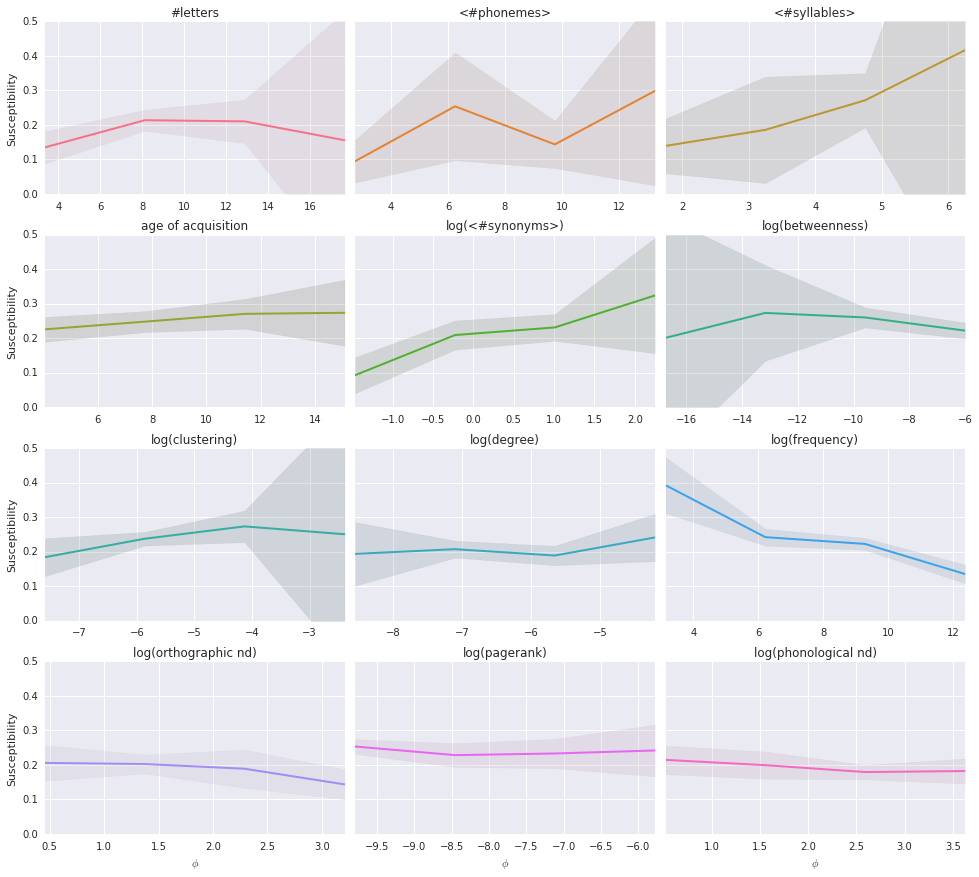

In [7]:
ordered_features = sorted(Substitution.__features__,
                          key=lambda f: Substitution._transformed_feature(f).__doc__)
g = sb.FacetGrid(data=susties, col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_susties)
g.set_titles('{col_name}')
g.set_xlabels(r'$\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-feature_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

Now with sentence-relative values.

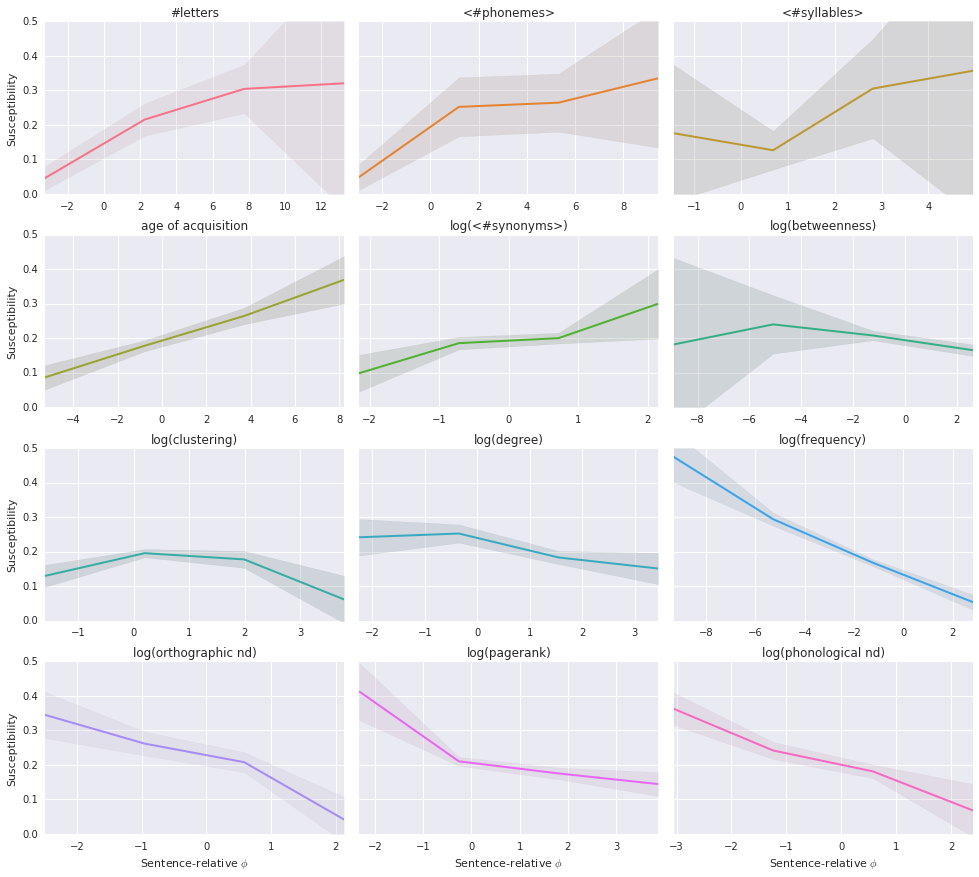

In [8]:
g = sb.FacetGrid(data=susties_rel, col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_susties, relative=True)
g.set_titles('{col_name}')
g.set_xlabels(r'Sentence-relative $\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-feature_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)

**Note on how confidence intervals are computed here**

There are three ways I can conceive of the computation represented in the graphs above:
1. For each word, we look at how many times it is substituted versus how many times it appears in a position where it could have been substituted. This is the *word*'s susceptibility, $\sigma(w)$. Then for each feature bin $b_i$ we take all the words such that $\phi(w) \in b_i$, average, and compute an asymptotic confidence interval based on how many words are in the bin. This fails for sentence-relative features, because a given word has different feature values depending on the sentence it appears in. So we discard this.
2. Do the same but at the feature value level. So we define a *feature value* susceptibility, $\sigma(f)$, and compute a confidence interval based on how many different feature values we have in the bin. The idea behind (1) and (2) is to look at the bin middle-value like the relevant object we're measuring, and we have several measures for each bin middle-value, hence the confidence interval. This is the way CIs are computed above.
3. Consider that we sample a multinomial process: each substitution is in fact the sampling of a feature value from one of the four bins. In that case, we can compute multinomial proportion CIs. This is also not satisfactory since in most cases not all feature values are available at the time of sampling, since most sentences don't range over all the feature's values. So for now I'm sticking with (2).

### 2.2 Feature susceptibilities, reduced to features we expose in the paper

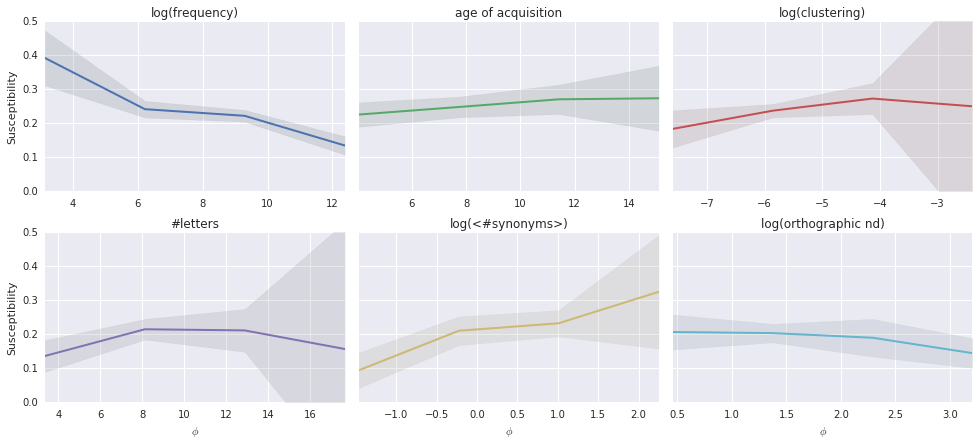

In [9]:
g = sb.FacetGrid(data=susties[susties['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_susties)
g.set_titles('{col_name}')
g.set_xlabels(r'$\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-feature_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

Now with sentence-relative values.

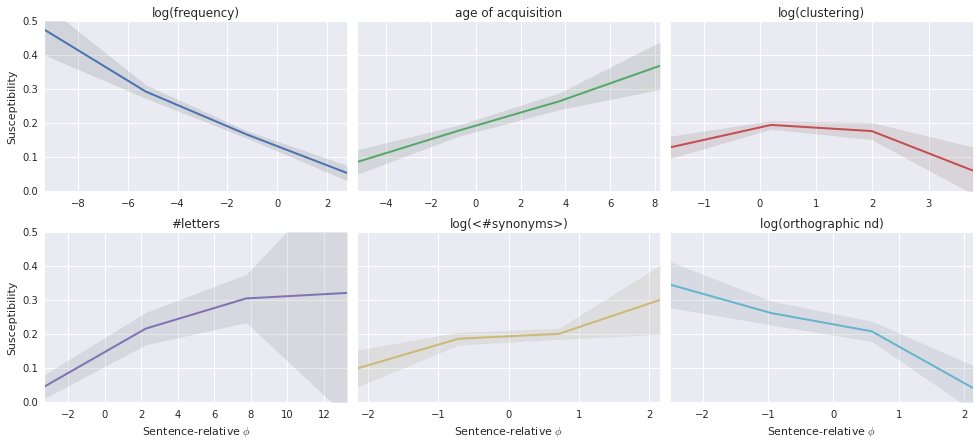

In [10]:
g = sb.FacetGrid(data=susties_rel[susties_rel['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_susties, relative=True)
g.set_titles('{col_name}')
g.set_xlabels(r'Sentence-relative $\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-feature_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)

## 3 On which POS tags do substitutions fall?

In [11]:
poses = susty_words[susty_words.feature == 'aoa'][['POS', 'cluster_id', 'destination_id',
                                                   'occurrence', 'source_id', 'target',
                                                   'weight', 'weight_appeared', 'word']]
# Only take first letter of POS code to denote categories,
# and group stopword-like categories together.
stop_poses = ['C', 'F', 'I', 'M', 'P', 'S', 'U']
poses['rPOS'] = poses['POS']\
    .apply(lambda x: x[0])\
    .apply(lambda x: 'Stopword-like' if x in stop_poses else x)

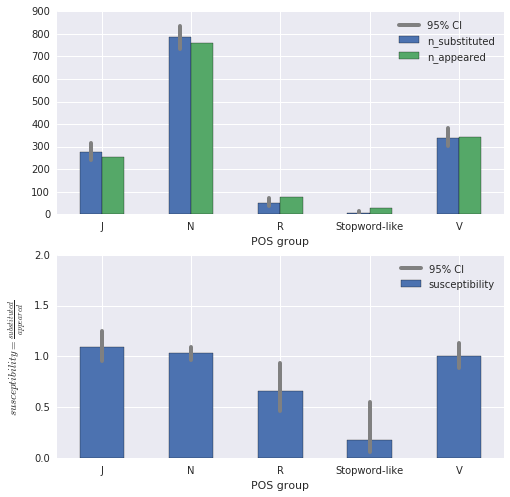

In [12]:
# Compute POS counts.
susty_pos = lambda x: ((x * poses.loc[x.index, 'weight']).sum() /
                       poses.loc[x.index, 'weight_appeared'].sum())
susties_pos = poses.groupby('rPOS')['target'].aggregate(
    {'susceptibility': susty_pos,
     'n_substituted': lambda x: (x * poses.loc[x.index, 'weight']).sum(),
     'n_appeared': lambda x: poses.loc[x.index, 'weight_appeared'].sum()}
).rename_axis('POS group')

# Plot.

fig, axes = plt.subplots(2, 1, figsize=(8, 8))
# Raw substituted and appeared values.
susties_pos[['n_substituted', 'n_appeared']].plot(ax=axes[0], kind='bar', rot=0)
# With their CIs.
total_substituted = susties_pos.n_substituted.sum()
cis = multinomial_proportions_confint(susties_pos.n_substituted.round(), method='goodman')
for i in range(len(susties_pos)):
    axes[0].plot([i-.125, i-.125], cis[i] * total_substituted, lw=4, color='grey',
                 label='95% CI' if i == 0 else None)
axes[0].legend()
# Substitutability values.
susties_pos['susceptibility'].plot(ax=axes[1], kind='bar', legend=True, ylim=(0, 2), rot=0)
axes[1].set_ylabel(r'$susceptibility = \frac{substituted}{appeared}$')
# With their CIs.
for i in range(len(susties_pos)):
    axes[1].plot([i, i], cis[i] * total_substituted / susties_pos.n_appeared.iloc[i],
                 lw=4, color='grey', label='95% CI' if i == 0 else None)
axes[1].legend(loc='best')
# Save if necessary.
if SAVE_FIGURES:
    fig.savefig(settings.FIGURE.format('all-pos_susceptibilities'),
                bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're in case (3) of the above explanation on confidence intervals (in section 2): it's really like a multinomial sampling, but not quite since not all POS tags are available to sample from in all the sentences. There's no way out of this, so we're going to use multinomial CIs. We can safely scale all the bars and CIs to their respective `n_appeared` values, since that is an independent given before the sampling.

**Are the appeared and substituted proportions statistically different?**

The only test we can easily do is a multinomial goodness-of-fit. This tells us if the `n_substituted` counts are significantly different from the reference `n_appeared` counts.

From there on we know a few things:
* Comparing a given POS's `n_substituted` count to its reference `n_appeared` count tells us if it's statistically different (< or >). We know this will be true individually for any POS that is out of its confidence region for the global goodness-of-fit test, since it's a weaker hypothesis (so the null rejection region will be wider, and the POS we're looking at is already in the rejection region for the global test). We don't know if it'll be true or not for POSes that are in their confidence region for the global test.
* Jointly comparing two POS's `n_substituted` counts to their reference `n_appeared` counts tells us if there is bias for one w.r.t. the other. This is also true for all pairs of POSes that are on alternate sides of their confidence region in the global test (for the same reasons as in the previous point). We don't know if it's true for the other POSes though.

In [13]:
# Test the n_substituted proportions are different from the n_appeared proportions
total_appeared = susties_pos.n_appeared.sum()
appeared_cis = multinomial_proportions_confint(susties_pos.n_appeared.round(), method='goodman')
differences = [(s < ci[0] * total_appeared) or (s > ci[1] * total_appeared)
               for s, ci in zip(susties_pos.n_substituted, appeared_cis)]
are_different = np.any(differences)
if are_different:
    print("Appeared and substituted proportions are different with p < .05")
    print("The following POS tags are out of their confidence region:",
          list(susties_pos.index[np.where(differences)[0]]))
else:
    print("Appeared and substituted proportions cannot be "
          "said different with p value better than .05")

Appeared and substituted proportions are different with p < .05
The following POS tags are out of their confidence region: ['R', 'Stopword-like']


## 4 Susceptibility in terms of absolute fractiles

In [14]:
def plot_absolute_fractile_distribution(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')

    # Compute feature bins.
    for bin_count in range(BIN_COUNT, 0, -1):
        try:
            x_fractiles = pd.qcut(data.value, bin_count, labels=False)
            break
        except ValueError:
            pass

    # Compute bin counts
    heights = np.zeros(bin_count)
    for i in range(bin_count):
        heights[i] = data[data.target & (x_fractiles == i)].weight.sum()
    total = sum(heights)
    cis = multinomial_proportions_confint(heights.round(), method='goodman') * total
    
    # Plot them.
    plt.plot(range(1, bin_count + 1), heights, color=color)
    plt.fill_between(range(1, bin_count + 1), cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.xticks(range(1, bin_count + 1))
    plt.xlim(1, bin_count)
    plt.ylim(0, None)

### 4.1 All features susceptibilities

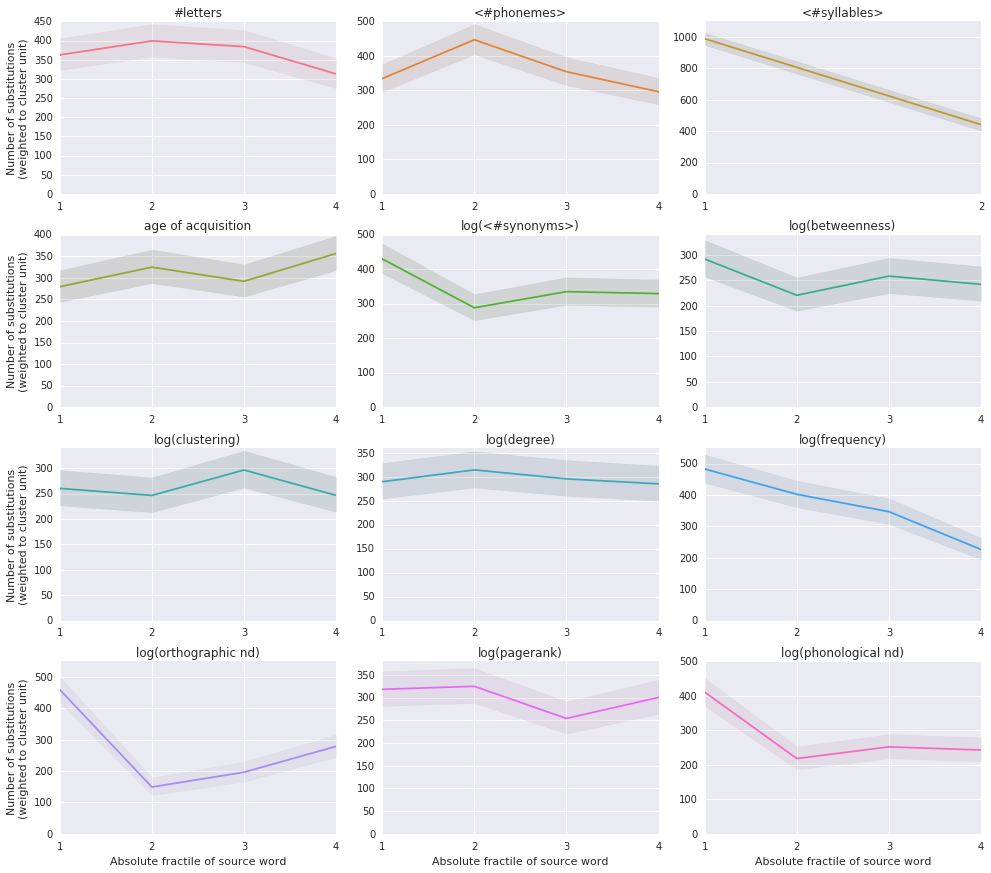

In [15]:
# Now plot.
g = sb.FacetGrid(data=susty_words, col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_absolute_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Absolute fractile of source word')
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-fractile_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're again in case (3) of the above explanation on confidence intervals (in section 2): it's really like a multinomial sampling, but not quite since not all absolute feature fractiles are available to sample from in all the sentences. Again, there's no way out of this, so we're going to use multinomial CIs.

### 4.2 Feature susceptibilities, reduced to features we expose in the paper

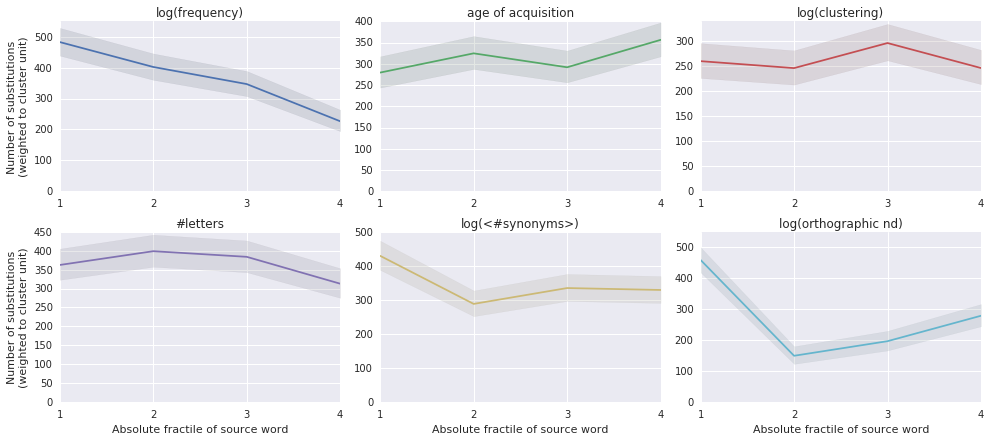

In [16]:
# Now plot.
g = sb.FacetGrid(data=susty_words[susty_words['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_absolute_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Absolute fractile of source word')
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-fractile_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

## 5 Susceptibility in terms of sentence fractiles

Build our data.

In [17]:
data = []
for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        
        for feature in Substitution.__features__:
            source, _ = substitution.features(feature)
            if np.isnan(source):
                # The source word has no feature value. We drop this substitution.
                continue
            sentence, _ = substitution.source_destination_features(feature)
            # Remove stopwords from this analysis, since we dropped substitutions on stopwords.
            dslice = slice(substitution.start,
                           substitution.start + len(substitution.destination.tokens))
            is_stopword = np.array([(lemma in stopwords) or (token in stopwords)
                                    for (lemma, token) in
                                    zip(substitution.source.lemmas[dslice],
                                        substitution.source.tokens[dslice])])
            sentence[is_stopword] = np.nan
            # Find the number of bins we'll use.
            values = set(sentence[np.isfinite(sentence)])
            if len(values) == 0 or len(values) == 1:
                # Only NaNs, or only one feature value. Drop this.
                continue
            start, stop = None, None
            power = 0
            while start is None:
                if int(BIN_COUNT / 2**power) * 2**power != BIN_COUNT:
                    raise ValueError('BIN_COUNT must be a power of 2')
                try:
                    start = 2**power * pd.qcut(sentence, int(BIN_COUNT / 2**power),
                                               labels=False)[substitution.position]
                    stop = start + 2**power
                except ValueError:
                    power += 1
            # And finally save the bin.
            data.append({'cluster_id': substitution.source.cluster.sid,
                         'destination_id': substitution.destination.sid,
                         'occurrence': substitution.occurrence,
                         'source_id': substitution.source.sid,
                         'feature': feature,
                         'start': start,
                         'stop': stop})

original_fractiles = pd.DataFrame(data)
del data

  0% (   73 of 14485) |                    | Elapsed Time: 0:00:01 ETA:  0:03:19

  1% (  146 of 14485) |                    | Elapsed Time: 0:00:02 ETA:  0:03:17

  1% (  182 of 14485) |                    | Elapsed Time: 0:00:02 ETA:  0:03:23

  1% (  255 of 14485) |                    | Elapsed Time: 0:00:03 ETA:  0:03:19

  2% (  333 of 14485) |                    | Elapsed Time: 0:00:04 ETA:  0:03:13

  2% (  363 of 14485) |                    | Elapsed Time: 0:00:04 ETA:  0:03:12

  3% (  445 of 14485) |                    | Elapsed Time: 0:00:05 ETA:  0:03:07

  3% (  521 of 14485) |                    | Elapsed Time: 0:00:06 ETA:  0:03:05

  3% (  544 of 14485) |                    | Elapsed Time: 0:00:07 ETA:  0:03:05

  4% (  626 of 14485) |                    | Elapsed Time: 0:00:08 ETA:  0:03:02

  4% (  695 of 14485) |                    | Elapsed Time: 0:00:09 ETA:  0:03:02

  5% (  725 of 14485) |#                   | Elapsed Time: 0:00:09 ETA:  0:03:02

  5% (  791 of 14485) |#                   | Elapsed Time: 0:00:10 ETA:  0:03:03

  5% (  859 of 14485) |#                   | Elapsed Time: 0:00:11 ETA:  0:03:06

  6% (  906 of 14485) |#                   | Elapsed Time: 0:00:12 ETA:  0:03:04

  6% (  971 of 14485) |#                   | Elapsed Time: 0:00:13 ETA:  0:03:09

  7% ( 1056 of 14485) |#                   | Elapsed Time: 0:00:14 ETA:  0:03:05

  7% ( 1087 of 14485) |#                   | Elapsed Time: 0:00:14 ETA:  0:03:05

  8% ( 1170 of 14485) |#                   | Elapsed Time: 0:00:15 ETA:  0:03:03

  8% ( 1268 of 14485) |#                   | Elapsed Time: 0:00:16 ETA:  0:02:53

  9% ( 1340 of 14485) |#                   | Elapsed Time: 0:00:17 ETA:  0:02:50

  9% ( 1419 of 14485) |#                   | Elapsed Time: 0:00:18 ETA:  0:02:45

 10% ( 1449 of 14485) |##                  | Elapsed Time: 0:00:19 ETA:  0:02:48

 10% ( 1510 of 14485) |##                  | Elapsed Time: 0:00:20 ETA:  0:02:48

 10% ( 1590 of 14485) |##                  | Elapsed Time: 0:00:21 ETA:  0:02:48

 11% ( 1630 of 14485) |##                  | Elapsed Time: 0:00:21 ETA:  0:02:49

 11% ( 1705 of 14485) |##                  | Elapsed Time: 0:00:22 ETA:  0:02:51

 12% ( 1781 of 14485) |##                  | Elapsed Time: 0:00:23 ETA:  0:02:55

 12% ( 1811 of 14485) |##                  | Elapsed Time: 0:00:24 ETA:  0:02:53

 13% ( 1888 of 14485) |##                  | Elapsed Time: 0:00:25 ETA:  0:02:51

 13% ( 1965 of 14485) |##                  | Elapsed Time: 0:00:26 ETA:  0:02:51

 13% ( 1992 of 14485) |##                  | Elapsed Time: 0:00:26 ETA:  0:02:49

 14% ( 2065 of 14485) |##                  | Elapsed Time: 0:00:27 ETA:  0:02:44

 14% ( 2144 of 14485) |##                  | Elapsed Time: 0:00:28 ETA:  0:02:43

 15% ( 2173 of 14485) |###                 | Elapsed Time: 0:00:29 ETA:  0:02:41

 15% ( 2255 of 14485) |###                 | Elapsed Time: 0:00:30 ETA:  0:02:37

 16% ( 2326 of 14485) |###                 | Elapsed Time: 0:00:31 ETA:  0:02:38

 16% ( 2354 of 14485) |###                 | Elapsed Time: 0:00:31 ETA:  0:02:37

 16% ( 2427 of 14485) |###                 | Elapsed Time: 0:00:32 ETA:  0:02:37

 17% ( 2498 of 14485) |###                 | Elapsed Time: 0:00:33 ETA:  0:02:38

 17% ( 2535 of 14485) |###                 | Elapsed Time: 0:00:33 ETA:  0:02:37

 17% ( 2606 of 14485) |###                 | Elapsed Time: 0:00:34 ETA:  0:02:37

 18% ( 2668 of 14485) |###                 | Elapsed Time: 0:00:35 ETA:  0:02:42

 18% ( 2716 of 14485) |###                 | Elapsed Time: 0:00:36 ETA:  0:02:43

 19% ( 2783 of 14485) |###                 | Elapsed Time: 0:00:37 ETA:  0:02:48

 19% ( 2843 of 14485) |###                 | Elapsed Time: 0:00:38 ETA:  0:02:51

 20% ( 2897 of 14485) |####                | Elapsed Time: 0:00:39 ETA:  0:02:53

 20% ( 2966 of 14485) |####                | Elapsed Time: 0:00:40 ETA:  0:02:54

 20% ( 3029 of 14485) |####                | Elapsed Time: 0:00:41 ETA:  0:02:56

 21% ( 3079 of 14485) |####                | Elapsed Time: 0:00:42 ETA:  0:02:55

 21% ( 3141 of 14485) |####                | Elapsed Time: 0:00:43 ETA:  0:02:58

 22% ( 3202 of 14485) |####                | Elapsed Time: 0:00:44 ETA:  0:02:57

 22% ( 3260 of 14485) |####                | Elapsed Time: 0:00:44 ETA:  0:02:52

 23% ( 3336 of 14485) |####                | Elapsed Time: 0:00:45 ETA:  0:02:48

 23% ( 3441 of 14485) |####                | Elapsed Time: 0:00:46 ETA:  0:02:32

 24% ( 3516 of 14485) |####                | Elapsed Time: 0:00:47 ETA:  0:02:29

 24% ( 3587 of 14485) |####                | Elapsed Time: 0:00:48 ETA:  0:02:25

 25% ( 3622 of 14485) |#####               | Elapsed Time: 0:00:49 ETA:  0:02:23

 25% ( 3704 of 14485) |#####               | Elapsed Time: 0:00:50 ETA:  0:02:15

 26% ( 3777 of 14485) |#####               | Elapsed Time: 0:00:51 ETA:  0:02:11

 26% ( 3803 of 14485) |#####               | Elapsed Time: 0:00:51 ETA:  0:02:12

 26% ( 3885 of 14485) |#####               | Elapsed Time: 0:00:52 ETA:  0:02:09

 27% ( 3964 of 14485) |#####               | Elapsed Time: 0:00:53 ETA:  0:02:14

 27% ( 3984 of 14485) |#####               | Elapsed Time: 0:00:53 ETA:  0:02:13

 27% ( 4046 of 14485) |#####               | Elapsed Time: 0:00:54 ETA:  0:02:17

 28% ( 4103 of 14485) |#####               | Elapsed Time: 0:00:55 ETA:  0:02:22

 28% ( 4165 of 14485) |#####               | Elapsed Time: 0:00:56 ETA:  0:02:23

 29% ( 4226 of 14485) |#####               | Elapsed Time: 0:00:57 ETA:  0:02:30

 29% ( 4289 of 14485) |#####               | Elapsed Time: 0:00:58 ETA:  0:02:34

 30% ( 4346 of 14485) |######              | Elapsed Time: 0:00:59 ETA:  0:02:35

 30% ( 4402 of 14485) |######              | Elapsed Time: 0:01:00 ETA:  0:02:45

 30% ( 4480 of 14485) |######              | Elapsed Time: 0:01:01 ETA:  0:02:44

 31% ( 4527 of 14485) |######              | Elapsed Time: 0:01:02 ETA:  0:02:42

 31% ( 4587 of 14485) |######              | Elapsed Time: 0:01:04 ETA:  0:03:04

 32% ( 4650 of 14485) |######              | Elapsed Time: 0:01:05 ETA:  0:03:00

 32% ( 4708 of 14485) |######              | Elapsed Time: 0:01:06 ETA:  0:02:59

 32% ( 4776 of 14485) |######              | Elapsed Time: 0:01:07 ETA:  0:02:55

 33% ( 4842 of 14485) |######              | Elapsed Time: 0:01:08 ETA:  0:02:53

 33% ( 4889 of 14485) |######              | Elapsed Time: 0:01:08 ETA:  0:02:56

 34% ( 4962 of 14485) |######              | Elapsed Time: 0:01:09 ETA:  0:02:47

 34% ( 5040 of 14485) |######              | Elapsed Time: 0:01:10 ETA:  0:02:46

 35% ( 5070 of 14485) |#######             | Elapsed Time: 0:01:11 ETA:  0:02:48

 35% ( 5140 of 14485) |#######             | Elapsed Time: 0:01:12 ETA:  0:02:20

 36% ( 5222 of 14485) |#######             | Elapsed Time: 0:01:13 ETA:  0:02:12

 36% ( 5251 of 14485) |#######             | Elapsed Time: 0:01:13 ETA:  0:02:14

 36% ( 5319 of 14485) |#######             | Elapsed Time: 0:01:14 ETA:  0:02:12

 37% ( 5397 of 14485) |#######             | Elapsed Time: 0:01:15 ETA:  0:02:07

 37% ( 5432 of 14485) |#######             | Elapsed Time: 0:01:16 ETA:  0:02:03

 38% ( 5506 of 14485) |#######             | Elapsed Time: 0:01:17 ETA:  0:02:02

 38% ( 5580 of 14485) |#######             | Elapsed Time: 0:01:18 ETA:  0:02:03

 38% ( 5613 of 14485) |#######             | Elapsed Time: 0:01:18 ETA:  0:02:02

 39% ( 5684 of 14485) |#######             | Elapsed Time: 0:01:19 ETA:  0:02:00

 39% ( 5749 of 14485) |#######             | Elapsed Time: 0:01:20 ETA:  0:02:06

 40% ( 5794 of 14485) |########            | Elapsed Time: 0:01:21 ETA:  0:02:06

 40% ( 5878 of 14485) |########            | Elapsed Time: 0:01:22 ETA:  0:01:59

 41% ( 5948 of 14485) |########            | Elapsed Time: 0:01:23 ETA:  0:02:01

 41% ( 5976 of 14485) |########            | Elapsed Time: 0:01:24 ETA:  0:01:59

 41% ( 6045 of 14485) |########            | Elapsed Time: 0:01:25 ETA:  0:02:00

 42% ( 6105 of 14485) |########            | Elapsed Time: 0:01:26 ETA:  0:02:04

 42% ( 6157 of 14485) |########            | Elapsed Time: 0:01:26 ETA:  0:02:04

 42% ( 6216 of 14485) |########            | Elapsed Time: 0:01:27 ETA:  0:02:08

 43% ( 6294 of 14485) |########            | Elapsed Time: 0:01:28 ETA:  0:02:02

 43% ( 6338 of 14485) |########            | Elapsed Time: 0:01:29 ETA:  0:01:56

 44% ( 6402 of 14485) |########            | Elapsed Time: 0:01:30 ETA:  0:02:03

 44% ( 6474 of 14485) |########            | Elapsed Time: 0:01:31 ETA:  0:02:01

 45% ( 6519 of 14485) |#########           | Elapsed Time: 0:01:31 ETA:  0:01:59

 45% ( 6603 of 14485) |#########           | Elapsed Time: 0:01:32 ETA:  0:01:53

 46% ( 6700 of 14485) |#########           | Elapsed Time: 0:01:34 ETA:  0:01:41

 46% ( 6766 of 14485) |#########           | Elapsed Time: 0:01:35 ETA:  0:01:37

 47% ( 6835 of 14485) |#########           | Elapsed Time: 0:01:36 ETA:  0:01:40

 47% ( 6881 of 14485) |#########           | Elapsed Time: 0:01:36 ETA:  0:01:43

 47% ( 6937 of 14485) |#########           | Elapsed Time: 0:01:37 ETA:  0:01:45

 48% ( 6995 of 14485) |#########           | Elapsed Time: 0:01:38 ETA:  0:01:49

 48% ( 7062 of 14485) |#########           | Elapsed Time: 0:01:39 ETA:  0:01:51

 49% ( 7141 of 14485) |#########           | Elapsed Time: 0:01:40 ETA:  0:01:52

 49% ( 7224 of 14485) |#########           | Elapsed Time: 0:01:41 ETA:  0:01:51

 50% ( 7243 of 14485) |##########          | Elapsed Time: 0:01:42 ETA:  0:01:52

 50% ( 7309 of 14485) |##########          | Elapsed Time: 0:01:43 ETA:  0:01:51

 50% ( 7386 of 14485) |##########          | Elapsed Time: 0:01:44 ETA:  0:01:47

 51% ( 7424 of 14485) |##########          | Elapsed Time: 0:01:44 ETA:  0:01:45

 51% ( 7499 of 14485) |##########          | Elapsed Time: 0:01:45 ETA:  0:01:37

 52% ( 7576 of 14485) |##########          | Elapsed Time: 0:01:46 ETA:  0:01:30

 52% ( 7605 of 14485) |##########          | Elapsed Time: 0:01:47 ETA:  0:01:24

 53% ( 7688 of 14485) |##########          | Elapsed Time: 0:01:48 ETA:  0:01:22

 53% ( 7786 of 14485) |##########          | Elapsed Time: 0:01:49 ETA:  0:01:18

 54% ( 7870 of 14485) |##########          | Elapsed Time: 0:01:50 ETA:  0:01:11

 55% ( 7967 of 14485) |###########         | Elapsed Time: 0:01:51 ETA:  0:01:05

 55% ( 8042 of 14485) |###########         | Elapsed Time: 0:01:52 ETA:  0:01:04

 55% ( 8111 of 14485) |###########         | Elapsed Time: 0:01:53 ETA:  0:01:06

 56% ( 8148 of 14485) |###########         | Elapsed Time: 0:01:53 ETA:  0:01:09

 56% ( 8212 of 14485) |###########         | Elapsed Time: 0:01:54 ETA:  0:01:15

 57% ( 8277 of 14485) |###########         | Elapsed Time: 0:01:55 ETA:  0:01:18

 57% ( 8329 of 14485) |###########         | Elapsed Time: 0:01:56 ETA:  0:01:21

 57% ( 8401 of 14485) |###########         | Elapsed Time: 0:01:57 ETA:  0:01:25

 58% ( 8474 of 14485) |###########         | Elapsed Time: 0:01:58 ETA:  0:01:29

 58% ( 8510 of 14485) |###########         | Elapsed Time: 0:01:59 ETA:  0:01:27

 59% ( 8578 of 14485) |###########         | Elapsed Time: 0:02:00 ETA:  0:01:29

 59% ( 8655 of 14485) |###########         | Elapsed Time: 0:02:01 ETA:  0:01:25

 60% ( 8691 of 14485) |############        | Elapsed Time: 0:02:01 ETA:  0:01:24

 60% ( 8764 of 14485) |############        | Elapsed Time: 0:02:02 ETA:  0:01:20

 61% ( 8842 of 14485) |############        | Elapsed Time: 0:02:03 ETA:  0:01:14

 61% ( 8873 of 14485) |############        | Elapsed Time: 0:02:04 ETA:  0:01:13

 61% ( 8941 of 14485) |############        | Elapsed Time: 0:02:05 ETA:  0:01:14

 62% ( 9009 of 14485) |############        | Elapsed Time: 0:02:06 ETA:  0:01:14

 62% ( 9054 of 14485) |############        | Elapsed Time: 0:02:06 ETA:  0:01:17

 62% ( 9104 of 14485) |############        | Elapsed Time: 0:02:07 ETA:  0:01:23

 63% ( 9153 of 14485) |############        | Elapsed Time: 0:02:08 ETA:  0:01:34

 63% ( 9221 of 14485) |############        | Elapsed Time: 0:02:09 ETA:  0:01:34

 63% ( 9235 of 14485) |############        | Elapsed Time: 0:02:10 ETA:  0:01:38

 64% ( 9297 of 14485) |############        | Elapsed Time: 0:02:11 ETA:  0:01:45

 64% ( 9365 of 14485) |############        | Elapsed Time: 0:02:12 ETA:  0:01:44

 65% ( 9416 of 14485) |#############       | Elapsed Time: 0:02:12 ETA:  0:01:47

 65% ( 9478 of 14485) |#############       | Elapsed Time: 0:02:14 ETA:  0:01:49

 65% ( 9544 of 14485) |#############       | Elapsed Time: 0:02:15 ETA:  0:01:46

 66% ( 9597 of 14485) |#############       | Elapsed Time: 0:02:15 ETA:  0:01:38

 66% ( 9662 of 14485) |#############       | Elapsed Time: 0:02:16 ETA:  0:01:30

 67% ( 9730 of 14485) |#############       | Elapsed Time: 0:02:17 ETA:  0:01:29

 67% ( 9778 of 14485) |#############       | Elapsed Time: 0:02:18 ETA:  0:01:24

 68% ( 9861 of 14485) |#############       | Elapsed Time: 0:02:19 ETA:  0:01:15

 68% ( 9935 of 14485) |#############       | Elapsed Time: 0:02:20 ETA:  0:01:11

 68% ( 9959 of 14485) |#############       | Elapsed Time: 0:02:20 ETA:  0:01:11

 69% (10015 of 14485) |#############       | Elapsed Time: 0:02:21 ETA:  0:01:13

 69% (10078 of 14485) |#############       | Elapsed Time: 0:02:22 ETA:  0:01:13

 70% (10140 of 14485) |##############      | Elapsed Time: 0:02:23 ETA:  0:01:10

 70% (10218 of 14485) |##############      | Elapsed Time: 0:02:24 ETA:  0:01:04

 71% (10290 of 14485) |##############      | Elapsed Time: 0:02:25 ETA:  0:01:01

 71% (10321 of 14485) |##############      | Elapsed Time: 0:02:26 ETA:  0:01:04

 71% (10386 of 14485) |##############      | Elapsed Time: 0:02:27 ETA:  0:01:10

 72% (10442 of 14485) |##############      | Elapsed Time: 0:02:28 ETA:  0:01:17

 72% (10502 of 14485) |##############      | Elapsed Time: 0:02:29 ETA:  0:01:16

 72% (10561 of 14485) |##############      | Elapsed Time: 0:02:30 ETA:  0:01:17

 73% (10625 of 14485) |##############      | Elapsed Time: 0:02:31 ETA:  0:01:19

 73% (10683 of 14485) |##############      | Elapsed Time: 0:02:32 ETA:  0:01:26

 74% (10735 of 14485) |##############      | Elapsed Time: 0:02:33 ETA:  0:01:36

 74% (10786 of 14485) |##############      | Elapsed Time: 0:02:34 ETA:  0:01:40

 74% (10838 of 14485) |##############      | Elapsed Time: 0:02:35 ETA:  0:01:46

 75% (10864 of 14485) |###############     | Elapsed Time: 0:02:36 ETA:  0:01:48

 75% (10917 of 14485) |###############     | Elapsed Time: 0:02:37 ETA:  0:01:44

 75% (10983 of 14485) |###############     | Elapsed Time: 0:02:38 ETA:  0:01:39

 76% (11045 of 14485) |###############     | Elapsed Time: 0:02:39 ETA:  0:01:41

 76% (11095 of 14485) |###############     | Elapsed Time: 0:02:40 ETA:  0:01:47

 76% (11151 of 14485) |###############     | Elapsed Time: 0:02:41 ETA:  0:01:43

 77% (11209 of 14485) |###############     | Elapsed Time: 0:02:42 ETA:  0:01:38

 77% (11226 of 14485) |###############     | Elapsed Time: 0:02:42 ETA:  0:01:36

 77% (11279 of 14485) |###############     | Elapsed Time: 0:02:43 ETA:  0:01:35

 78% (11330 of 14485) |###############     | Elapsed Time: 0:02:44 ETA:  0:01:35

 78% (11384 of 14485) |###############     | Elapsed Time: 0:02:45 ETA:  0:01:42

 78% (11407 of 14485) |###############     | Elapsed Time: 0:02:46 ETA:  0:01:48

 79% (11467 of 14485) |###############     | Elapsed Time: 0:02:47 ETA:  0:01:43

 79% (11525 of 14485) |###############     | Elapsed Time: 0:02:48 ETA:  0:01:36

 80% (11588 of 14485) |################    | Elapsed Time: 0:02:49 ETA:  0:01:37

 80% (11638 of 14485) |################    | Elapsed Time: 0:02:50 ETA:  0:01:39

 80% (11694 of 14485) |################    | Elapsed Time: 0:02:51 ETA:  0:01:36

 80% (11730 of 14485) |################    | Elapsed Time: 0:02:53 ETA:  0:02:32

 81% (11770 of 14485) |################    | Elapsed Time: 0:02:54 ETA:  0:02:36

 81% (11813 of 14485) |################    | Elapsed Time: 0:02:55 ETA:  0:02:38

 81% (11870 of 14485) |################    | Elapsed Time: 0:02:56 ETA:  0:02:40

 82% (11929 of 14485) |################    | Elapsed Time: 0:02:57 ETA:  0:02:38

 82% (11951 of 14485) |################    | Elapsed Time: 0:02:57 ETA:  0:02:47

 82% (12002 of 14485) |################    | Elapsed Time: 0:02:58 ETA:  0:02:39

 83% (12059 of 14485) |################    | Elapsed Time: 0:02:59 ETA:  0:02:32

 83% (12113 of 14485) |################    | Elapsed Time: 0:03:00 ETA:  0:02:33

 83% (12132 of 14485) |################    | Elapsed Time: 0:03:01 ETA:  0:01:33

 84% (12183 of 14485) |################    | Elapsed Time: 0:03:02 ETA:  0:01:30

 84% (12237 of 14485) |################    | Elapsed Time: 0:03:03 ETA:  0:01:22

 84% (12298 of 14485) |################    | Elapsed Time: 0:03:04 ETA:  0:01:19

 85% (12313 of 14485) |#################   | Elapsed Time: 0:03:04 ETA:  0:01:20

 85% (12368 of 14485) |#################   | Elapsed Time: 0:03:05 ETA:  0:01:18

 85% (12424 of 14485) |#################   | Elapsed Time: 0:03:06 ETA:  0:01:15

 86% (12494 of 14485) |#################   | Elapsed Time: 0:03:07 ETA:  0:01:11

 86% (12552 of 14485) |#################   | Elapsed Time: 0:03:08 ETA:  0:01:10

 87% (12609 of 14485) |#################   | Elapsed Time: 0:03:09 ETA:  0:01:05

 87% (12664 of 14485) |#################   | Elapsed Time: 0:03:10 ETA:  0:01:03

 87% (12675 of 14485) |#################   | Elapsed Time: 0:03:10 ETA:  0:01:06

 87% (12731 of 14485) |#################   | Elapsed Time: 0:03:11 ETA:  0:01:07

 88% (12788 of 14485) |#################   | Elapsed Time: 0:03:12 ETA:  0:01:05

 88% (12856 of 14485) |#################   | Elapsed Time: 0:03:14 ETA:  0:01:03

 89% (12918 of 14485) |#################   | Elapsed Time: 0:03:15 ETA:  0:01:00

 89% (12969 of 14485) |#################   | Elapsed Time: 0:03:16 ETA:  0:01:03

 90% (13037 of 14485) |##################  | Elapsed Time: 0:03:17 ETA:  0:00:58

 90% (13099 of 14485) |##################  | Elapsed Time: 0:03:18 ETA:  0:00:54

 90% (13144 of 14485) |##################  | Elapsed Time: 0:03:19 ETA:  0:01:00

 91% (13218 of 14485) |##################  | Elapsed Time: 0:03:20 ETA:  0:00:54

 91% (13272 of 14485) |##################  | Elapsed Time: 0:03:21 ETA:  0:00:56

 91% (13326 of 14485) |##################  | Elapsed Time: 0:03:22 ETA:  0:01:00

 92% (13387 of 14485) |##################  | Elapsed Time: 0:03:23 ETA:  0:00:52

 92% (13399 of 14485) |##################  | Elapsed Time: 0:03:23 ETA:  0:00:55

 92% (13459 of 14485) |##################  | Elapsed Time: 0:03:24 ETA:  0:00:54

 93% (13520 of 14485) |##################  | Elapsed Time: 0:03:25 ETA:  0:00:53

 93% (13580 of 14485) |##################  | Elapsed Time: 0:03:26 ETA:  0:00:41

 94% (13636 of 14485) |##################  | Elapsed Time: 0:03:27 ETA:  0:00:45

 94% (13695 of 14485) |##################  | Elapsed Time: 0:03:28 ETA:  0:00:43

 94% (13748 of 14485) |##################  | Elapsed Time: 0:03:29 ETA:  0:00:42

 95% (13761 of 14485) |################### | Elapsed Time: 0:03:30 ETA:  0:00:39

 95% (13814 of 14485) |################### | Elapsed Time: 0:03:31 ETA:  0:00:43

 95% (13869 of 14485) |################### | Elapsed Time: 0:03:32 ETA:  0:00:42

 96% (13926 of 14485) |################### | Elapsed Time: 0:03:33 ETA:  0:00:43

 96% (13942 of 14485) |################### | Elapsed Time: 0:03:33 ETA:  0:00:46

 96% (13998 of 14485) |################### | Elapsed Time: 0:03:34 ETA:  0:00:49

 97% (14054 of 14485) |################### | Elapsed Time: 0:03:35 ETA:  0:00:48

 97% (14109 of 14485) |################### | Elapsed Time: 0:03:36 ETA:  0:00:50

 97% (14123 of 14485) |################### | Elapsed Time: 0:03:36 ETA:  0:00:51

 97% (14175 of 14485) |################### | Elapsed Time: 0:03:37 ETA:  0:00:52

 98% (14230 of 14485) |################### | Elapsed Time: 0:03:38 ETA:  0:00:49

 98% (14304 of 14485) |################### | Elapsed Time: 0:03:39 ETA:  0:00:40

 99% (14361 of 14485) |################### | Elapsed Time: 0:03:40 ETA:  0:00:38

 99% (14418 of 14485) |################### | Elapsed Time: 0:03:41 ETA:  0:00:36

 99% (14466 of 14485) |################### | Elapsed Time: 0:03:42 ETA:  0:00:39

100% (14485 of 14485) |####################| Elapsed Time: 0:03:43 Time: 0:03:43


Compute the weight of each substitution, according to what other substitutions it's pooled with, and the size of its bin. Letting:
* $n_d(i) = \#\text{substitutions with same durl as substitution }i$
* and $n_c(i) = \#\text{substitutions with same cluster as substitution }i$ (counting substitutions with the same durl as one)
* $p(i) = \text{precision (width) of the bin we assigned to substitution }i$

Then we define the weight of a substitution $i$:
$$w(i) = \frac{1}{n_d(i) n_c(i) p(i)}$$

In [18]:
fractiles = original_fractiles.copy()
divide_sum = lambda x: x / x.sum()

# Weight is 1 at first.
fractiles['weight'] = 1
# Divided by the number of substitutions that share a durl.
fractiles['weight'] = fractiles\
    .groupby(['destination_id', 'occurrence', 'feature'])['weight']\
    .transform(divide_sum)
# Divided by the number of substitutions that share a cluster. (Using divide_sum,
# where we divide by the sum of weights, ensures we count only one for each group
# of substitutions sharing a same durl.)
fractiles['weight'] = fractiles\
    .groupby(['cluster_id', 'feature'])['weight']\
    .transform(divide_sum)
# And finally divide by the precision of the bin we put a substitution in.
fractiles['weight'] = fractiles['weight'] / (fractiles['stop'] - fractiles['start'])

Now for each feature, count the sum of weights in each bin and plot that.

In [19]:
def plot_fractile_distribution(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    
    # Compute bin counts
    heights = np.zeros(BIN_COUNT)
    for i in range(BIN_COUNT):
        heights[i] = data[(data['start'] <= i) & (i < data['stop'])]['weight'].sum()
    total = sum(heights)
    cis = multinomial_proportions_confint(heights.round(), method='goodman') * total
    
    # Plot them.
    plt.plot(range(1, BIN_COUNT + 1), heights, color=color)
    plt.fill_between(range(1, BIN_COUNT + 1), cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.xticks(range(1, BIN_COUNT + 1))
    plt.ylim(0, None)

### 5.1 All features susceptibilities

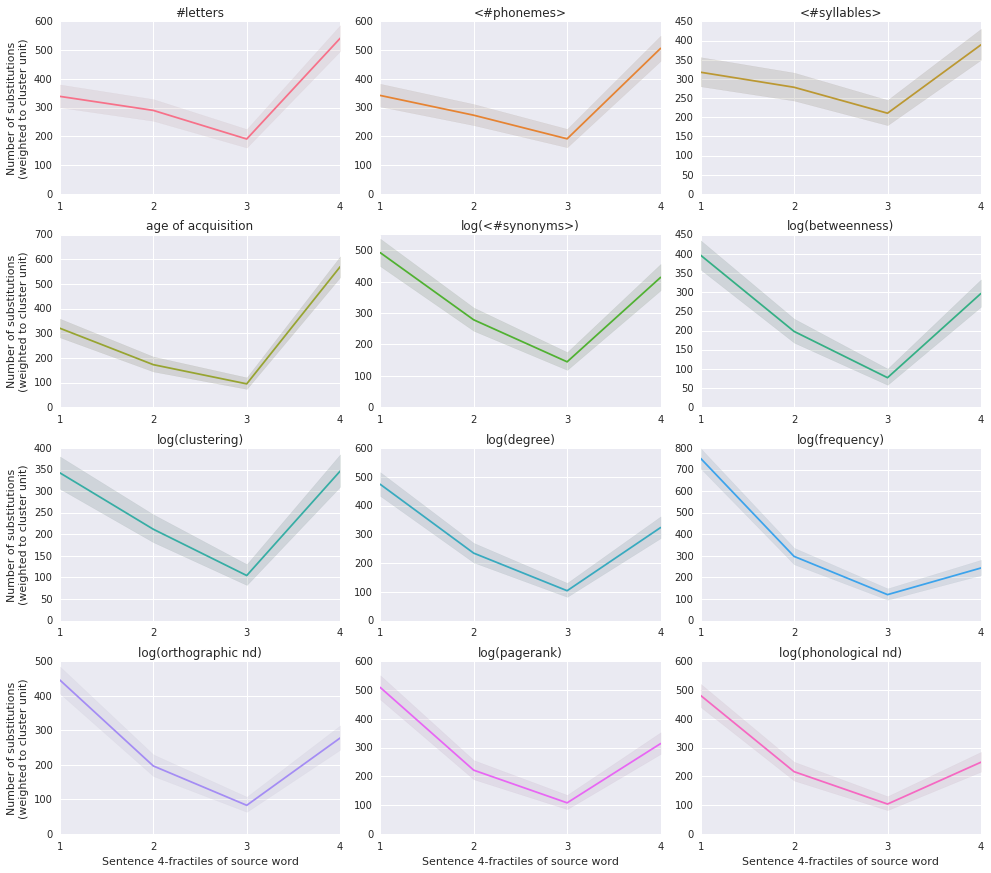

In [20]:
# Now plot.
g = sb.FacetGrid(data=fractiles, col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Sentence {}-fractiles of source word'.format(BIN_COUNT))
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-fractile_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're finally in a real multinomial sampling (and it's the only time). So we're going to use multinomial CIs.

### 5.2 Feature susceptibilities, reduced to features we expose in the paper

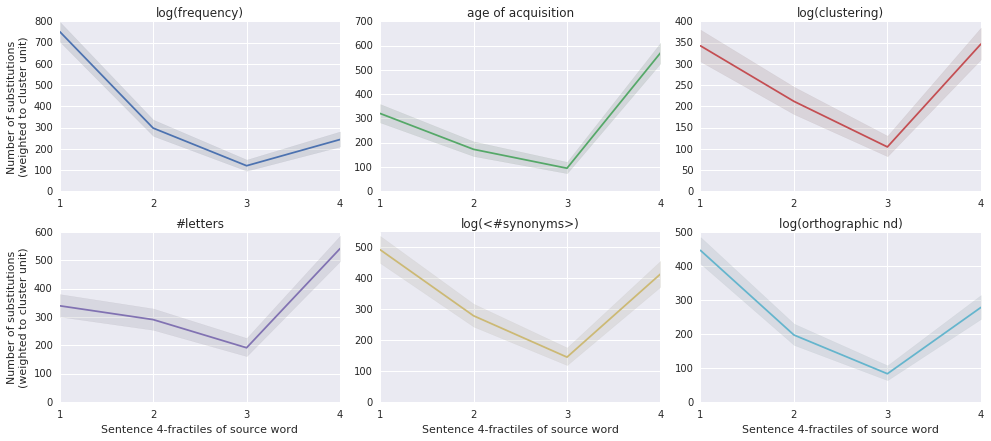

In [21]:
# Now plot.
g = sb.FacetGrid(data=fractiles[fractiles['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Sentence {}-fractiles of source word'.format(BIN_COUNT))
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-fractile_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)